In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm

In [62]:
def get_cutoff_indices(df: pd.DataFrame, n_features: int) -> list:
    """
    Get the indices of the cutoffs for each feature in the dataframe
    """
    df_len = len(df)
    cutoff_indices = []

    
    for i in range(df_len-n_features):
        first_index = i
        last_index = i + n_features-1
        next_index = i + n_features
        cutoff_indices.append((first_index, last_index, next_index))

    return cutoff_indices


In [94]:
df_total = pd.read_parquet('../data/transformed/transformed_filtered_yellow_tripdata_2023-10.parquet')

In [95]:
df = df_total[df_total['PULocationID'] == 43]

In [96]:
cutoff_indices = get_cutoff_indices(df, 24)

In [97]:
cutoff_indices[-1]

(719, 742, 743)

In [98]:
n_features = 24

In [99]:
df

pickup_hour  rides  PULocationID
9672  2023-10-01 00:00:00   24.0            43
9673  2023-10-01 01:00:00   14.0            43
9674  2023-10-01 02:00:00    6.0            43
9675  2023-10-01 03:00:00    0.0            43
9676  2023-10-01 04:00:00    3.0            43
...                   ...    ...           ...
10411 2023-10-31 19:00:00   51.0            43
10412 2023-10-31 20:00:00   88.0            43
10413 2023-10-31 21:00:00   49.0            43
10414 2023-10-31 22:00:00   37.0            43
10415 2023-10-31 23:00:00   29.0            43

[744 rows x 3 columns]

In [100]:
# create feature matrix
feature_matrix = np.zeros(shape=(len(cutoff_indices), n_features))

feature_matrix[0] = df['rides'].iloc[0:24].values

In [101]:
feature_matrix.shape

(720, 24)

In [102]:
n_features

24

In [103]:
feature_matrix[0]

feature_matrix[1] = df['rides'].iloc[1:25].values

In [104]:
feature_matrix[1]

array([ 14.,   6.,   0.,   3.,   3.,  14.,   8.,  26.,  51.,  86., 110.,
       148., 136., 143., 153., 216., 137., 104.,  63.,  35.,  30.,  29.,
        10.,   1.])

In [105]:
cutoff_indices[-1]

(719, 742, 743)

In [71]:
feature_matrix[-1]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.])

In [107]:
# create cutoff indices
cutoff_indices = get_cutoff_indices(df, n_features=24)

# create feature matrix
feature_matrix = np.zeros(shape=(len(cutoff_indices), n_features))

# loop through the cutoff indices and create the feature matrix
for i, (first_index,last_index, next_index) in tqdm(enumerate(cutoff_indices)):
    feature_matrix[i] = df['rides'].iloc[first_index:last_index+1].values




720it [00:00, 58568.30it/s]


In [108]:
import numpy as np
from tqdm import tqdm

def create_feature_matrix_and_target(df, cutoff_indices):
    """
    Creates a feature matrix and a target vector from a DataFrame using sliding window indices.
    
    Args:
    - df: A pandas DataFrame containing the time series data (e.g., column 'rides').
    - cutoff_indices: A list of tuples (first_index, last_index, next_index) generated by the `get_cutoff_indices()` function.
    - n_features: The number of previous time steps to use as features (sliding window size).
    
    Returns:
    - feature_matrix: A NumPy array where each row contains a sliding window values.
    - target_vector: A NumPy array containing the target value (the value at `next_index` for each window).
    """
    
    # Generate the feature matrix using list comprehension
    feature_matrix = np.array([
        df['rides'].iloc[first_index:last_index+1].values 
        for first_index, last_index, _ in tqdm(cutoff_indices)
    ])
    
    # Generate the target vector using list comprehension
    target_vector = np.array([
        df['rides'].iloc[next_index] for _, _, next_index in tqdm(cutoff_indices)
    ])
    
    return feature_matrix, target_vector

In [109]:
# Create both feature matrix and target vector
feature_matrix, target_vector = create_feature_matrix_and_target(df, cutoff_indices)

100%|██████████| 720/720 [00:00<00:00, 191205.45it/s]


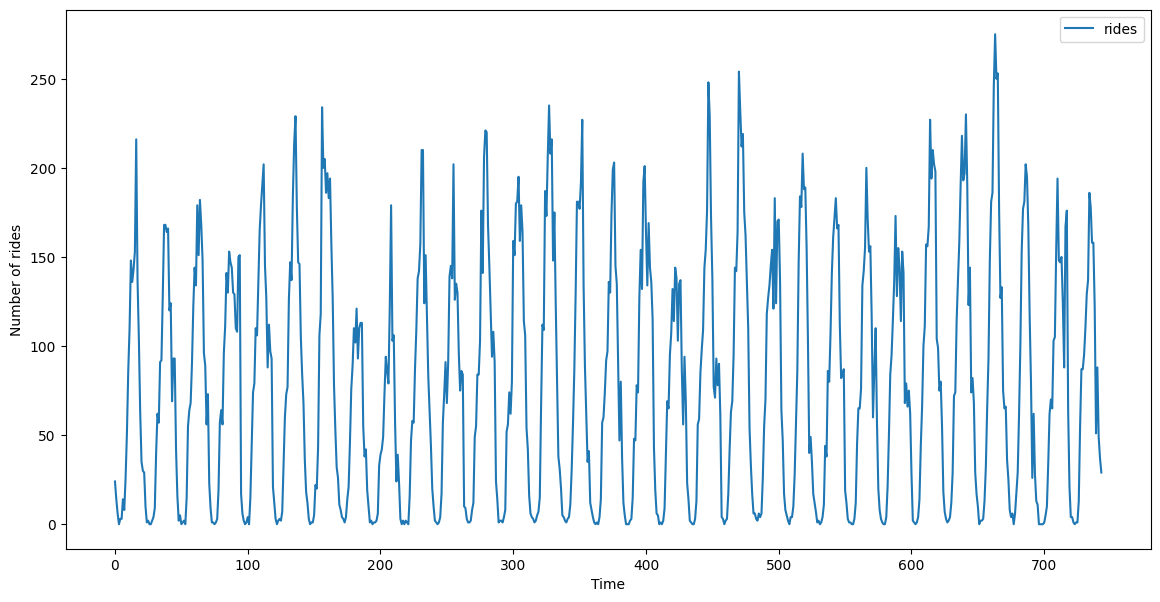

In [111]:
# plot df rides

import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))

plt.plot(df['rides'].values, label='rides')
plt.xlabel('Time')
plt.ylabel('Number of rides')
plt.legend()
plt.show()

In [133]:

def process_feature_target_by_PULocationID(file_path, n_features):
    """
    Process a parquet file, segmenting the data by PULocationID, and apply sliding window transformation
    for each PULocationID. Outputs a single DataFrame with PULocationID, features, and target.
    
    Args:
    - file_path: Path to the parquet file containing data.
    - n_features: The number of previous time steps to use as features (sliding window size).
    
    Returns:
    - A single DataFrame with PULocationID, features (feature_0 to feature_{n_features-1}), and target.
    """
    # Load the parquet file
    df = pd.read_parquet(file_path)

    # Get unique PULocationIDs
    unique_pulocation_ids = df['PULocationID'].unique()
    
    # List to store the results
    rows = []

    # Process each PULocationID separately
    for pulocation_id in tqdm(unique_pulocation_ids):
        # Filter the dataframe for this specific PULocationID
        df_location = df[df['PULocationID'] == pulocation_id].sort_values('pickup_hour')

        # Generate cutoff indices for the time series
        cutoff_indices = get_cutoff_indices(df_location, n_features=n_features)
        
        if len(cutoff_indices) == 0:
            # Skip if there's not enough data to generate the feature matrix
            continue
        
        # Create feature matrix and target vector
        feature_matrix, target_vector = create_feature_matrix_and_target(df_location, cutoff_indices)
        
        # Append the PULocationID, features, and target to the result list
        for i in range(feature_matrix.shape[0]):
            row = [pulocation_id] + list(feature_matrix[i]) + [target_vector[i]]
            rows.append(row)

    # Create a DataFrame with the collected rows
    columns = ['PULocationID'] + [f'feature_{i}' for i in range(n_features)] + ['target']
    final_df = pd.DataFrame(rows, columns=columns)
    
    return final_df

In [134]:
pulocationid_results = process_feature_target_by_PULocationID('../data/transformed/transformed_filtered_yellow_tripdata_2023-10.parquet', n_features=24)

100%|██████████| 256/256 [00:06<00:00, 39.80it/s]


In [136]:
pulocationid_results[pulocationid_results['PULocationID'] == 43]

PULocationID  feature_0  feature_1  feature_2  feature_3  feature_4  \
9360             43       24.0       14.0        6.0        0.0        3.0   
9361             43       14.0        6.0        0.0        3.0        3.0   
9362             43        6.0        0.0        3.0        3.0       14.0   
9363             43        0.0        3.0        3.0       14.0        8.0   
9364             43        3.0        3.0       14.0        8.0       26.0   
...             ...        ...        ...        ...        ...        ...   
10075            43       88.0      167.0      176.0       64.0       21.0   
10076            43      167.0      176.0       64.0       21.0        4.0   
10077            43      176.0       64.0       21.0        4.0        4.0   
10078            43       64.0       21.0        4.0        4.0        1.0   
10079            43       21.0        4.0        4.0        1.0        0.0   

       feature_5  feature_6  feature_7  feature_8  ...  feature_15  \
9360         3.0       14.0        8.0       26.0  ...       153.0   
9361        14.0        8.0       26.0       51.0  ...       216.0   
9362         8.0       26.0       51.0       86.0  ...       137.0   
9363        26.0       51.0       86.0      110.0  ...       104.0   
9364        51.0       86.0      110.0      148.0  ...        63.0   
...          ...        ...        ...        ...  ...         ...   
10075        4.0        4.0        1.0        0.0  ...        95.0   
10076        4.0        1.0        0.0        1.0  ...       110.0   
10077        1.0        0.0        1.0        1.0  ...       129.0   
10078        0.0        1.0        1.0       13.0  ...       137.0   
10079        1.0        1.0       13.0       55.0  ...       186.0   

       feature_16  feature_17  feature_18  feature_19  feature_20  feature_21  \
9360        216.0       137.0       104.0        63.0        35.0        30.0   
9361        137.0       104.0        63.0        35.0        30.0        29.0   
9362        104.0        63.0        35.0        30.0        29.0        10.0   
9363         63.0        35.0        30.0        29.0        10.0         1.0   
9364         35.0        30.0        29.0        10.0         1.0         2.0   
...           ...         ...         ...         ...         ...         ...   
10075       110.0       129.0       137.0       186.0       178.0       158.0   
10076       129.0       137.0       186.0       178.0       158.0       158.0   
10077       137.0       186.0       178.0       158.0       158.0       122.0   
10078       186.0       178.0       158.0       158.0       122.0        51.0   
10079       178.0       158.0       158.0       122.0        51.0        88.0   

       feature_22  feature_23  target  
9360         29.0        10.0     1.0  
9361         10.0         1.0     2.0  
9362          1.0         2.0     0.0  
9363          2.0         0.0     0.0  
9364          0.0         0.0     2.0  
...           ...         ...     ...  
10075       158.0       122.0    51.0  
10076       122.0        51.0    88.0  
10077        51.0        88.0    49.0  
10078        88.0        49.0    37.0  
10079        49.0        37.0    29.0  

[720 rows x 26 columns]

In [152]:
import os
import pandas as pd

def process_all_transformed_files(input_dir='../data/transformed', output_dir='../data/time_series', n_features=24):
    """
    Process all files in the 'data/transformed' folder that follow the naming pattern
    'transformed_filtered_{type}_{year}-{month}.parquet' and save them to 'data/time_series' 
    with the name 'ts_{type}_{year}-{month}.parquet'.
    
    Args:
    - input_dir: Directory where the transformed parquet files are located.
    - output_dir: Directory where the time series parquet files will be saved.
    - n_features: Number of previous time steps to use as features (default is 24).
    
    Returns:
    - None: The function saves the processed files in the output directory.
    """
    # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)
    
    # Iterate over all parquet files in the input directory
    for filename in os.listdir(input_dir):
        if filename.endswith('.parquet') and filename.startswith('transformed_filtered_'):
            try:
                # Remove the prefix and suffix to get the core file name
                file_core = filename.replace('transformed_filtered_', '').replace('.parquet', '')

                # Use the last underscore to separate the type from the year-month
                data_type, year_month = file_core.rsplit('_', 1)
                
                # Extract year and month from the year_month string
                year, month = year_month.split('-')
                # Create the new filename following the pattern ts_{type}_{year}-{month}.parquet
                output_filename = f'ts_{data_type}_{year}-{month}.parquet'
                output_path = os.path.join(output_dir, output_filename)

                # Skip the file if it already exists
                if os.path.exists(output_path):
                    print(f"{output_filename} already exists. Skipping.")
                    continue

                # Full path to the current input file
                input_path = os.path.join(input_dir, filename)

                # Process the file to get the time series data for each PULocationID
                print(f"Processing {filename}...")
                final_df = process_feature_target_by_PULocationID(input_path, n_features)

                # Save the processed DataFrame as a parquet file
                final_df.to_parquet(output_path)
                print(f"Saved {output_filename} to {output_dir}")

            except Exception as e:
                print(f"Error processing {filename}: {e}")


In [153]:
# Execute the process in all 'data/transformed'
process_all_transformed_files(input_dir='../data/transformed', output_dir='../data/time_series', n_features=24)


yellow_tripdata_2022-03
yellow_tripdata 2022-03
Processing transformed_filtered_yellow_tripdata_2022-03.parquet...


100%|██████████| 257/257 [00:06<00:00, 40.14it/s]


Saved ts_yellow_tripdata_2022-03.parquet to ../data/time_series
yellow_tripdata_2021-01
yellow_tripdata 2021-01
Processing transformed_filtered_yellow_tripdata_2021-01.parquet...


100%|██████████| 258/258 [00:06<00:00, 41.11it/s]


Saved ts_yellow_tripdata_2021-01.parquet to ../data/time_series
green_tripdata_2021-01
green_tripdata 2021-01
Processing transformed_filtered_green_tripdata_2021-01.parquet...


100%|██████████| 251/251 [00:06<00:00, 40.22it/s]


Saved ts_green_tripdata_2021-01.parquet to ../data/time_series
yellow_tripdata_2023-12
yellow_tripdata 2023-12
Processing transformed_filtered_yellow_tripdata_2023-12.parquet...


100%|██████████| 259/259 [00:06<00:00, 40.15it/s]


Saved ts_yellow_tripdata_2023-12.parquet to ../data/time_series
yellow_tripdata_2022-07
yellow_tripdata 2022-07
Processing transformed_filtered_yellow_tripdata_2022-07.parquet...


100%|██████████| 257/257 [00:06<00:00, 41.02it/s]


Saved ts_yellow_tripdata_2022-07.parquet to ../data/time_series
fhv_tripdata_2021-08
fhv_tripdata 2021-08
Processing transformed_filtered_fhv_tripdata_2021-08.parquet...


100%|██████████| 261/261 [00:06<00:00, 41.29it/s]


Saved ts_fhv_tripdata_2021-08.parquet to ../data/time_series
green_tripdata_2021-07
green_tripdata 2021-07
Processing transformed_filtered_green_tripdata_2021-07.parquet...


100%|██████████| 253/253 [00:06<00:00, 40.19it/s]


Saved ts_green_tripdata_2021-07.parquet to ../data/time_series
fhv_tripdata_2021-12
fhv_tripdata 2021-12
Processing transformed_filtered_fhv_tripdata_2021-12.parquet...


100%|██████████| 262/262 [00:06<00:00, 40.99it/s]


Saved ts_fhv_tripdata_2021-12.parquet to ../data/time_series
green_tripdata_2022-02
green_tripdata 2022-02
Processing transformed_filtered_green_tripdata_2022-02.parquet...


100%|██████████| 230/230 [00:05<00:00, 44.49it/s]


Saved ts_green_tripdata_2022-02.parquet to ../data/time_series
yellow_tripdata_2022-12
yellow_tripdata 2022-12
Processing transformed_filtered_yellow_tripdata_2022-12.parquet...


100%|██████████| 260/260 [00:06<00:00, 42.27it/s]


Saved ts_yellow_tripdata_2022-12.parquet to ../data/time_series
green_tripdata_2021-03
green_tripdata 2021-03
Processing transformed_filtered_green_tripdata_2021-03.parquet...


100%|██████████| 254/254 [00:06<00:00, 42.14it/s]


Saved ts_green_tripdata_2021-03.parquet to ../data/time_series
yellow_tripdata_2021-03
yellow_tripdata 2021-03
Processing transformed_filtered_yellow_tripdata_2021-03.parquet...


100%|██████████| 258/258 [00:06<00:00, 41.12it/s]


Saved ts_yellow_tripdata_2021-03.parquet to ../data/time_series
green_tripdata_2021-11
green_tripdata 2021-11
Processing transformed_filtered_green_tripdata_2021-11.parquet...


100%|██████████| 256/256 [00:05<00:00, 43.59it/s]


Saved ts_green_tripdata_2021-11.parquet to ../data/time_series
fhv_tripdata_2022-04
fhv_tripdata 2022-04
Processing transformed_filtered_fhv_tripdata_2022-04.parquet...


100%|██████████| 261/261 [00:06<00:00, 42.60it/s]


Saved ts_fhv_tripdata_2022-04.parquet to ../data/time_series
fhv_tripdata_2021-11
fhv_tripdata 2021-11
Processing transformed_filtered_fhv_tripdata_2021-11.parquet...


100%|██████████| 259/259 [00:06<00:00, 42.96it/s]


Saved ts_fhv_tripdata_2021-11.parquet to ../data/time_series
yellow_tripdata_2022-01
yellow_tripdata 2022-01
Processing transformed_filtered_yellow_tripdata_2022-01.parquet...


100%|██████████| 257/257 [00:06<00:00, 38.10it/s]


Saved ts_yellow_tripdata_2022-01.parquet to ../data/time_series
green_tripdata_2022-05
green_tripdata 2022-05
Processing transformed_filtered_green_tripdata_2022-05.parquet...


100%|██████████| 240/240 [00:05<00:00, 42.38it/s]


Saved ts_green_tripdata_2022-05.parquet to ../data/time_series
yellow_tripdata_2023-10
yellow_tripdata 2023-10
Processing transformed_filtered_yellow_tripdata_2023-10.parquet...


100%|██████████| 256/256 [00:06<00:00, 41.70it/s]


Saved ts_yellow_tripdata_2023-10.parquet to ../data/time_series
fhvhv_tripdata_2021-08
fhvhv_tripdata 2021-08
Processing transformed_filtered_fhvhv_tripdata_2021-08.parquet...


100%|██████████| 261/261 [00:06<00:00, 42.80it/s]


Saved ts_fhvhv_tripdata_2021-08.parquet to ../data/time_series
fhvhv_tripdata_2021-06
fhvhv_tripdata 2021-06
Processing transformed_filtered_fhvhv_tripdata_2021-06.parquet...


100%|██████████| 263/263 [00:06<00:00, 42.76it/s]


Saved ts_fhvhv_tripdata_2021-06.parquet to ../data/time_series
fhvhv_tripdata_2022-04
fhvhv_tripdata 2022-04
Processing transformed_filtered_fhvhv_tripdata_2022-04.parquet...


100%|██████████| 262/262 [00:06<00:00, 39.16it/s]


Saved ts_fhvhv_tripdata_2022-04.parquet to ../data/time_series
fhvhv_tripdata_2021-12
fhvhv_tripdata 2021-12
Processing transformed_filtered_fhvhv_tripdata_2021-12.parquet...


100%|██████████| 262/262 [00:06<00:00, 40.91it/s]


Saved ts_fhvhv_tripdata_2021-12.parquet to ../data/time_series
yellow_tripdata_2023-01
yellow_tripdata 2023-01
Processing transformed_filtered_yellow_tripdata_2023-01.parquet...


100%|██████████| 257/257 [00:06<00:00, 42.44it/s]


Saved ts_yellow_tripdata_2023-01.parquet to ../data/time_series
green_tripdata_2022-01
green_tripdata 2022-01
Processing transformed_filtered_green_tripdata_2022-01.parquet...


100%|██████████| 231/231 [00:05<00:00, 41.75it/s]


Saved ts_green_tripdata_2022-01.parquet to ../data/time_series
fhv_tripdata_2021-01
fhv_tripdata 2021-01
Processing transformed_filtered_fhv_tripdata_2021-01.parquet...


100%|██████████| 261/261 [00:06<00:00, 42.10it/s]


Saved ts_fhv_tripdata_2021-01.parquet to ../data/time_series
green_tripdata_2021-08
green_tripdata 2021-08
Processing transformed_filtered_green_tripdata_2021-08.parquet...


100%|██████████| 251/251 [00:06<00:00, 38.42it/s]


Saved ts_green_tripdata_2021-08.parquet to ../data/time_series
fhv_tripdata_2022-02
fhv_tripdata 2022-02
Processing transformed_filtered_fhv_tripdata_2022-02.parquet...


100%|██████████| 259/259 [00:05<00:00, 45.26it/s]


Saved ts_fhv_tripdata_2022-02.parquet to ../data/time_series
yellow_tripdata_2021-08
yellow_tripdata 2021-08
Processing transformed_filtered_yellow_tripdata_2021-08.parquet...


100%|██████████| 260/260 [00:06<00:00, 42.45it/s]


Saved ts_yellow_tripdata_2021-08.parquet to ../data/time_series
yellow_tripdata_2023-09
yellow_tripdata 2023-09
Processing transformed_filtered_yellow_tripdata_2023-09.parquet...


100%|██████████| 258/258 [00:06<00:00, 42.33it/s]


Saved ts_yellow_tripdata_2023-09.parquet to ../data/time_series
yellow_tripdata_2023-02
yellow_tripdata 2023-02
Processing transformed_filtered_yellow_tripdata_2023-02.parquet...


100%|██████████| 258/258 [00:05<00:00, 45.38it/s]


Saved ts_yellow_tripdata_2023-02.parquet to ../data/time_series
fhv_tripdata_2021-02
fhv_tripdata 2021-02
Processing transformed_filtered_fhv_tripdata_2021-02.parquet...


100%|██████████| 261/261 [00:06<00:00, 40.92it/s]


Saved ts_fhv_tripdata_2021-02.parquet to ../data/time_series
fhvhv_tripdata_2022-02
fhvhv_tripdata 2022-02
Processing transformed_filtered_fhvhv_tripdata_2022-02.parquet...


100%|██████████| 262/262 [00:05<00:00, 46.00it/s]


Saved ts_fhvhv_tripdata_2022-02.parquet to ../data/time_series
yellow_tripdata_2021-11
yellow_tripdata 2021-11
Processing transformed_filtered_yellow_tripdata_2021-11.parquet...


100%|██████████| 259/259 [00:06<00:00, 43.10it/s]


Saved ts_yellow_tripdata_2021-11.parquet to ../data/time_series
yellow_tripdata_2022-10
yellow_tripdata 2022-10
Processing transformed_filtered_yellow_tripdata_2022-10.parquet...


100%|██████████| 260/260 [00:06<00:00, 41.31it/s]


Saved ts_yellow_tripdata_2022-10.parquet to ../data/time_series
fhv_tripdata_2022-05
fhv_tripdata 2022-05
Processing transformed_filtered_fhv_tripdata_2022-05.parquet...


100%|██████████| 261/261 [00:06<00:00, 41.92it/s]


Saved ts_fhv_tripdata_2022-05.parquet to ../data/time_series
fhvhv_tripdata_2021-01
fhvhv_tripdata 2021-01
Processing transformed_filtered_fhvhv_tripdata_2021-01.parquet...


100%|██████████| 262/262 [00:06<00:00, 37.89it/s]


Saved ts_fhvhv_tripdata_2021-01.parquet to ../data/time_series
fhvhv_tripdata_2022-05
fhvhv_tripdata 2022-05
Processing transformed_filtered_fhvhv_tripdata_2022-05.parquet...


100%|██████████| 262/262 [00:06<00:00, 43.28it/s]


Saved ts_fhvhv_tripdata_2022-05.parquet to ../data/time_series
fhv_tripdata_2021-06
fhv_tripdata 2021-06
Processing transformed_filtered_fhv_tripdata_2021-06.parquet...


100%|██████████| 261/261 [00:06<00:00, 42.84it/s]


Saved ts_fhv_tripdata_2021-06.parquet to ../data/time_series
green_tripdata_2022-03
green_tripdata 2022-03
Processing transformed_filtered_green_tripdata_2022-03.parquet...


100%|██████████| 236/236 [00:05<00:00, 40.80it/s]


Saved ts_green_tripdata_2022-03.parquet to ../data/time_series
yellow_tripdata_2023-03
yellow_tripdata 2023-03
Processing transformed_filtered_yellow_tripdata_2023-03.parquet...


100%|██████████| 261/261 [00:06<00:00, 38.41it/s]


Saved ts_yellow_tripdata_2023-03.parquet to ../data/time_series
fhvhv_tripdata_2021-05
fhvhv_tripdata 2021-05
Processing transformed_filtered_fhvhv_tripdata_2021-05.parquet...


100%|██████████| 261/261 [00:06<00:00, 41.26it/s]


Saved ts_fhvhv_tripdata_2021-05.parquet to ../data/time_series
fhvhv_tripdata_2021-04
fhvhv_tripdata 2021-04
Processing transformed_filtered_fhvhv_tripdata_2021-04.parquet...


100%|██████████| 262/262 [00:06<00:00, 42.85it/s]


Saved ts_fhvhv_tripdata_2021-04.parquet to ../data/time_series
fhv_tripdata_2021-10
fhv_tripdata 2021-10
Processing transformed_filtered_fhv_tripdata_2021-10.parquet...


100%|██████████| 262/262 [00:06<00:00, 41.98it/s]


Saved ts_fhv_tripdata_2021-10.parquet to ../data/time_series
yellow_tripdata_2021-06
yellow_tripdata 2021-06
Processing transformed_filtered_yellow_tripdata_2021-06.parquet...


100%|██████████| 261/261 [00:06<00:00, 41.58it/s]


Saved ts_yellow_tripdata_2021-06.parquet to ../data/time_series
fhvhv_tripdata_2021-11
fhvhv_tripdata 2021-11
Processing transformed_filtered_fhvhv_tripdata_2021-11.parquet...


100%|██████████| 261/261 [00:06<00:00, 38.53it/s]


Saved ts_fhvhv_tripdata_2021-11.parquet to ../data/time_series
yellow_tripdata_2022-04
yellow_tripdata 2022-04
Processing transformed_filtered_yellow_tripdata_2022-04.parquet...


100%|██████████| 257/257 [00:06<00:00, 41.71it/s]


Saved ts_yellow_tripdata_2022-04.parquet to ../data/time_series
yellow_tripdata_2023-08
yellow_tripdata 2023-08
Processing transformed_filtered_yellow_tripdata_2023-08.parquet...


100%|██████████| 259/259 [00:06<00:00, 40.65it/s]


Saved ts_yellow_tripdata_2023-08.parquet to ../data/time_series
yellow_tripdata_2022-06
yellow_tripdata 2022-06
Processing transformed_filtered_yellow_tripdata_2022-06.parquet...


100%|██████████| 261/261 [00:06<00:00, 40.25it/s]


Saved ts_yellow_tripdata_2022-06.parquet to ../data/time_series
green_tripdata_2022-04
green_tripdata 2022-04
Processing transformed_filtered_green_tripdata_2022-04.parquet...


100%|██████████| 239/239 [00:05<00:00, 40.66it/s]


Saved ts_green_tripdata_2022-04.parquet to ../data/time_series
green_tripdata_2021-05
green_tripdata 2021-05
Processing transformed_filtered_green_tripdata_2021-05.parquet...


100%|██████████| 253/253 [00:06<00:00, 37.33it/s]


Saved ts_green_tripdata_2021-05.parquet to ../data/time_series
green_tripdata_2021-09
green_tripdata 2021-09
Processing transformed_filtered_green_tripdata_2021-09.parquet...


100%|██████████| 256/256 [00:06<00:00, 41.65it/s]


Saved ts_green_tripdata_2021-09.parquet to ../data/time_series
yellow_tripdata_2023-04
yellow_tripdata 2023-04
Processing transformed_filtered_yellow_tripdata_2023-04.parquet...


100%|██████████| 258/258 [00:06<00:00, 40.63it/s]


Saved ts_yellow_tripdata_2023-04.parquet to ../data/time_series
fhvhv_tripdata_2021-09
fhvhv_tripdata 2021-09
Processing transformed_filtered_fhvhv_tripdata_2021-09.parquet...


100%|██████████| 263/263 [00:06<00:00, 40.53it/s]


Saved ts_fhvhv_tripdata_2021-09.parquet to ../data/time_series
yellow_tripdata_2022-09
yellow_tripdata 2022-09
Processing transformed_filtered_yellow_tripdata_2022-09.parquet...


100%|██████████| 260/260 [00:06<00:00, 41.32it/s]


Saved ts_yellow_tripdata_2022-09.parquet to ../data/time_series
green_tripdata_2021-10
green_tripdata 2021-10
Processing transformed_filtered_green_tripdata_2021-10.parquet...


100%|██████████| 256/256 [00:06<00:00, 39.40it/s]


Saved ts_green_tripdata_2021-10.parquet to ../data/time_series
yellow_tripdata_2021-04
yellow_tripdata 2021-04
Processing transformed_filtered_yellow_tripdata_2021-04.parquet...


100%|██████████| 261/261 [00:06<00:00, 41.46it/s]


Saved ts_yellow_tripdata_2021-04.parquet to ../data/time_series
fhvhv_tripdata_2022-01
fhvhv_tripdata 2022-01
Processing transformed_filtered_fhvhv_tripdata_2022-01.parquet...


100%|██████████| 260/260 [00:06<00:00, 41.77it/s]


Saved ts_fhvhv_tripdata_2022-01.parquet to ../data/time_series
fhv_tripdata_2021-03
fhv_tripdata 2021-03
Processing transformed_filtered_fhv_tripdata_2021-03.parquet...


100%|██████████| 260/260 [00:06<00:00, 40.34it/s]


Saved ts_fhv_tripdata_2021-03.parquet to ../data/time_series
yellow_tripdata_2022-11
yellow_tripdata 2022-11
Processing transformed_filtered_yellow_tripdata_2022-11.parquet...


100%|██████████| 260/260 [00:06<00:00, 38.40it/s]


Saved ts_yellow_tripdata_2022-11.parquet to ../data/time_series
yellow_tripdata_2021-05
yellow_tripdata 2021-05
Processing transformed_filtered_yellow_tripdata_2021-05.parquet...


100%|██████████| 260/260 [00:06<00:00, 40.01it/s]


Saved ts_yellow_tripdata_2021-05.parquet to ../data/time_series
fhv_tripdata_2021-07
fhv_tripdata 2021-07
Processing transformed_filtered_fhv_tripdata_2021-07.parquet...


100%|██████████| 261/261 [00:06<00:00, 39.76it/s]


Saved ts_fhv_tripdata_2021-07.parquet to ../data/time_series
yellow_tripdata_2023-05
yellow_tripdata 2023-05
Processing transformed_filtered_yellow_tripdata_2023-05.parquet...


100%|██████████| 261/261 [00:06<00:00, 40.45it/s]


Saved ts_yellow_tripdata_2023-05.parquet to ../data/time_series
yellow_tripdata_2021-12
yellow_tripdata 2021-12
Processing transformed_filtered_yellow_tripdata_2021-12.parquet...


100%|██████████| 260/260 [00:06<00:00, 39.07it/s]


Saved ts_yellow_tripdata_2021-12.parquet to ../data/time_series
yellow_tripdata_2022-02
yellow_tripdata 2022-02
Processing transformed_filtered_yellow_tripdata_2022-02.parquet...


100%|██████████| 255/255 [00:05<00:00, 44.48it/s]


Saved ts_yellow_tripdata_2022-02.parquet to ../data/time_series
fhv_tripdata_2022-07
fhv_tripdata 2022-07
Processing transformed_filtered_fhv_tripdata_2022-07.parquet...


100%|██████████| 261/261 [00:06<00:00, 41.15it/s]


Saved ts_fhv_tripdata_2022-07.parquet to ../data/time_series
yellow_tripdata_2021-07
yellow_tripdata 2021-07
Processing transformed_filtered_yellow_tripdata_2021-07.parquet...


100%|██████████| 260/260 [00:06<00:00, 40.24it/s]


Saved ts_yellow_tripdata_2021-07.parquet to ../data/time_series
green_tripdata_2021-06
green_tripdata 2021-06
Processing transformed_filtered_green_tripdata_2021-06.parquet...


100%|██████████| 252/252 [00:06<00:00, 41.91it/s]


Saved ts_green_tripdata_2021-06.parquet to ../data/time_series
green_tripdata_2021-02
green_tripdata 2021-02
Processing transformed_filtered_green_tripdata_2021-02.parquet...


100%|██████████| 248/248 [00:06<00:00, 39.78it/s]


Saved ts_green_tripdata_2021-02.parquet to ../data/time_series
yellow_tripdata_2021-02
yellow_tripdata 2021-02
Processing transformed_filtered_yellow_tripdata_2021-02.parquet...


100%|██████████| 260/260 [00:06<00:00, 42.99it/s]


Saved ts_yellow_tripdata_2021-02.parquet to ../data/time_series
yellow_tripdata_2022-05
yellow_tripdata 2022-05
Processing transformed_filtered_yellow_tripdata_2022-05.parquet...


100%|██████████| 259/259 [00:06<00:00, 42.16it/s]


Saved ts_yellow_tripdata_2022-05.parquet to ../data/time_series
fhvhv_tripdata_2021-02
fhvhv_tripdata 2021-02
Processing transformed_filtered_fhvhv_tripdata_2021-02.parquet...


100%|██████████| 261/261 [00:05<00:00, 43.58it/s]


Saved ts_fhvhv_tripdata_2021-02.parquet to ../data/time_series
fhvhv_tripdata_2021-03
fhvhv_tripdata 2021-03
Processing transformed_filtered_fhvhv_tripdata_2021-03.parquet...


100%|██████████| 262/262 [00:06<00:00, 41.82it/s]


Saved ts_fhvhv_tripdata_2021-03.parquet to ../data/time_series
yellow_tripdata_2021-10
yellow_tripdata 2021-10
Processing transformed_filtered_yellow_tripdata_2021-10.parquet...


100%|██████████| 261/261 [00:06<00:00, 38.34it/s]


Saved ts_yellow_tripdata_2021-10.parquet to ../data/time_series
fhv_tripdata_2021-05
fhv_tripdata 2021-05
Processing transformed_filtered_fhv_tripdata_2021-05.parquet...


100%|██████████| 261/261 [00:06<00:00, 42.24it/s]


Saved ts_fhv_tripdata_2021-05.parquet to ../data/time_series
yellow_tripdata_2023-11
yellow_tripdata 2023-11
Processing transformed_filtered_yellow_tripdata_2023-11.parquet...


100%|██████████| 258/258 [00:06<00:00, 42.41it/s]


Saved ts_yellow_tripdata_2023-11.parquet to ../data/time_series
fhv_tripdata_2022-06
fhv_tripdata 2022-06
Processing transformed_filtered_fhv_tripdata_2022-06.parquet...


100%|██████████| 261/261 [00:06<00:00, 42.98it/s]


Saved ts_fhv_tripdata_2022-06.parquet to ../data/time_series
yellow_tripdata_2022-08
yellow_tripdata 2022-08
Processing transformed_filtered_yellow_tripdata_2022-08.parquet...


100%|██████████| 262/262 [00:06<00:00, 41.41it/s]


Saved ts_yellow_tripdata_2022-08.parquet to ../data/time_series
fhvhv_tripdata_2022-06
fhvhv_tripdata 2022-06
Processing transformed_filtered_fhvhv_tripdata_2022-06.parquet...


100%|██████████| 261/261 [00:06<00:00, 38.04it/s]


Saved ts_fhvhv_tripdata_2022-06.parquet to ../data/time_series
fhv_tripdata_2022-03
fhv_tripdata 2022-03
Processing transformed_filtered_fhv_tripdata_2022-03.parquet...


100%|██████████| 260/260 [00:06<00:00, 41.88it/s]


Saved ts_fhv_tripdata_2022-03.parquet to ../data/time_series
yellow_tripdata_2023-07
yellow_tripdata 2023-07
Processing transformed_filtered_yellow_tripdata_2023-07.parquet...


100%|██████████| 255/255 [00:06<00:00, 42.09it/s]


Saved ts_yellow_tripdata_2023-07.parquet to ../data/time_series
fhvhv_tripdata_2022-03
fhvhv_tripdata 2022-03
Processing transformed_filtered_fhvhv_tripdata_2022-03.parquet...


100%|██████████| 263/263 [00:06<00:00, 41.77it/s]


Saved ts_fhvhv_tripdata_2022-03.parquet to ../data/time_series
fhv_tripdata_2021-04
fhv_tripdata 2021-04
Processing transformed_filtered_fhv_tripdata_2021-04.parquet...


100%|██████████| 262/262 [00:06<00:00, 39.31it/s]


Saved ts_fhv_tripdata_2021-04.parquet to ../data/time_series
yellow_tripdata_2023-06
yellow_tripdata 2023-06
Processing transformed_filtered_yellow_tripdata_2023-06.parquet...


100%|██████████| 258/258 [00:06<00:00, 41.61it/s]


Saved ts_yellow_tripdata_2023-06.parquet to ../data/time_series
fhv_tripdata_2021-09
fhv_tripdata 2021-09
Processing transformed_filtered_fhv_tripdata_2021-09.parquet...


100%|██████████| 260/260 [00:06<00:00, 42.98it/s]


Saved ts_fhv_tripdata_2021-09.parquet to ../data/time_series
yellow_tripdata_2021-09
yellow_tripdata 2021-09
Processing transformed_filtered_yellow_tripdata_2021-09.parquet...


100%|██████████| 261/261 [00:06<00:00, 43.00it/s]


Saved ts_yellow_tripdata_2021-09.parquet to ../data/time_series
fhvhv_tripdata_2021-07
fhvhv_tripdata 2021-07
Processing transformed_filtered_fhvhv_tripdata_2021-07.parquet...


100%|██████████| 260/260 [00:06<00:00, 41.13it/s]


Saved ts_fhvhv_tripdata_2021-07.parquet to ../data/time_series
green_tripdata_2022-06
green_tripdata 2022-06
Processing transformed_filtered_green_tripdata_2022-06.parquet...


100%|██████████| 242/242 [00:06<00:00, 38.85it/s]


Saved ts_green_tripdata_2022-06.parquet to ../data/time_series
green_tripdata_2021-04
green_tripdata 2021-04
Processing transformed_filtered_green_tripdata_2021-04.parquet...


100%|██████████| 255/255 [00:05<00:00, 42.69it/s]


Saved ts_green_tripdata_2021-04.parquet to ../data/time_series
green_tripdata_2021-12
green_tripdata 2021-12
Processing transformed_filtered_green_tripdata_2021-12.parquet...


100%|██████████| 256/256 [00:06<00:00, 41.74it/s]


Saved ts_green_tripdata_2021-12.parquet to ../data/time_series
fhv_tripdata_2022-01
fhv_tripdata 2022-01
Processing transformed_filtered_fhv_tripdata_2022-01.parquet...


100%|██████████| 259/259 [00:06<00:00, 42.49it/s]


Saved ts_fhv_tripdata_2022-01.parquet to ../data/time_series
green_tripdata_2022-07
green_tripdata 2022-07
Processing transformed_filtered_green_tripdata_2022-07.parquet...


100%|██████████| 244/244 [00:05<00:00, 41.81it/s]


Saved ts_green_tripdata_2022-07.parquet to ../data/time_series
fhvhv_tripdata_2021-10
fhvhv_tripdata 2021-10
Processing transformed_filtered_fhvhv_tripdata_2021-10.parquet...


100%|██████████| 262/262 [00:06<00:00, 37.89it/s]


Saved ts_fhvhv_tripdata_2021-10.parquet to ../data/time_series
